<a href="https://colab.research.google.com/github/YuxinLiu-Adeline/Time-series-project-Python-Version/blob/main/DASC_6510_02_Time_Series_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# Data source:
# Nischal Lal. Kalimati Tarkari Dataset [Data set]. Kaggle.
# Retrieved August 25, 2025, from
# https://www.kaggle.com/datasets/nischallal/kalimati-tarkari-dataset/data

#Upload data (manual upload)
from google.colab import files
import pandas as pd

# Upload your CSV (e.g., Kalimati_Tarkari_Dataset.csv)
uploaded = files.upload()

# Pick the first uploaded CSV file
filename = next((k for k in uploaded.keys() if k.lower().endswith(".csv")), None)
if filename is None:
    raise ValueError("Please upload a .csv file.")
data = pd.read_csv(filename)

print("Loaded file:", filename)
print("Shape:", data.shape)
data.head()


Saving Kalimati_Tarkari_Dataset.csv to Kalimati_Tarkari_Dataset (1).csv
Loaded file: Kalimati_Tarkari_Dataset (1).csv
Shape: (280862, 6)


/tmp/ipython-input-157098130.py:12: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filename)


,Commodity,Date,Unit,Minimum,Maximum,Average
0,Tomato Big(Nepali),6/16/2013,Kg,35,40,37.5
1,Tomato Small(Local),6/16/2013,Kg,26,32,29.0
2,Potato Red,6/16/2013,Kg,20,21,20.5
3,Potato White,6/16/2013,Kg,15,16,15.5
4,Onion Dry (Indian),6/16/2013,Kg,28,30,29.0


In [17]:
# Imports, basic setup
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 11

# Ensure Date is datetime
if "Date" not in data.columns:
    raise ValueError("Column 'Date' is missing in the dataset.")
data["Date"] = pd.to_datetime(data["Date"], format="%Y-%m-%d", errors="coerce")


In [28]:
def clean_price_cols(df, cols=("Maximum", "Minimum", "Average")):
    for col in cols:
        if col in df.columns:
            # remove thousands separators and any non-numeric characters (e.g., "Rs ")
            df[col] = (df[col].astype(str)
                               .str.replace(",", "", regex=False)
                               .str.replace(r"[^\d\.\-]", "", regex=True))
            # coerce to float
            df[col] = pd.to_numeric(df[col], errors="coerce")
    return df

# Clean on both the raw dataframe and the filtered one (if they already exist)
data = clean_price_cols(data)
filtered = clean_price_cols(filtered)

print("Dtypes after cleaning:\n", filtered.dtypes)

Dtypes after cleaning:
 Commodity            object
Date         datetime64[ns]
Unit                 object
Minimum             float64
Maximum             float64
Average             float64
Group                object
dtype: object


In [29]:
# Filtering, grouping


# Select commodities (same as your R version)
selected_commodities = [
    "Potato Red", "Potato Red(Indian)",
    "Tomato Small(Local)", "Tomato Small(Indian)", "Tomato Small(Tunnel)",
    "Papaya(Indian)", "Papaya(Nepali)"
]

filtered = (
    data[
        (data["Commodity"].isin(selected_commodities)) &
        (data["Date"] >= pd.Timestamp("2019-06-01"))
    ]
    .copy()
)

if "Maximum" not in filtered.columns:
    raise ValueError("Column 'Maximum' not found in dataset. Check column names.")

def map_group(commodity: str) -> str:
    if commodity in ["Potato Red", "Potato Red(Indian)"]:
        return "Potato Red"
    if commodity in ["Tomato Small(Local)", "Tomato Small(Indian)", "Tomato Small(Tunnel)"]:
        return "Tomato Small"
    if commodity in ["Papaya(Indian)", "Papaya(Nepali)"]:
        return "Papaya"
    return commodity

filtered["Group"] = filtered["Commodity"].map(map_group)

print("Filtered shape:", filtered.shape)
filtered.head()


Filtered shape: (3045, 7)


,Commodity,Date,Unit,Minimum,Maximum,Average,Group
229773,Papaya(Indian),2022-04-19,KG,80.0,90.0,86.67,Papaya
229774,Papaya(Nepali),2022-04-19,KG,60.0,70.0,66.67,Papaya
229781,Potato Red,2022-04-19,KG,30.0,32.0,31.00,Potato Red
229782,Potato Red(Indian),2022-04-19,KG,25.0,26.0,25.50,Potato Red
229800,Tomato Small(Indian),2022-04-19,KG,40.0,50.0,45.00,Tomato Small


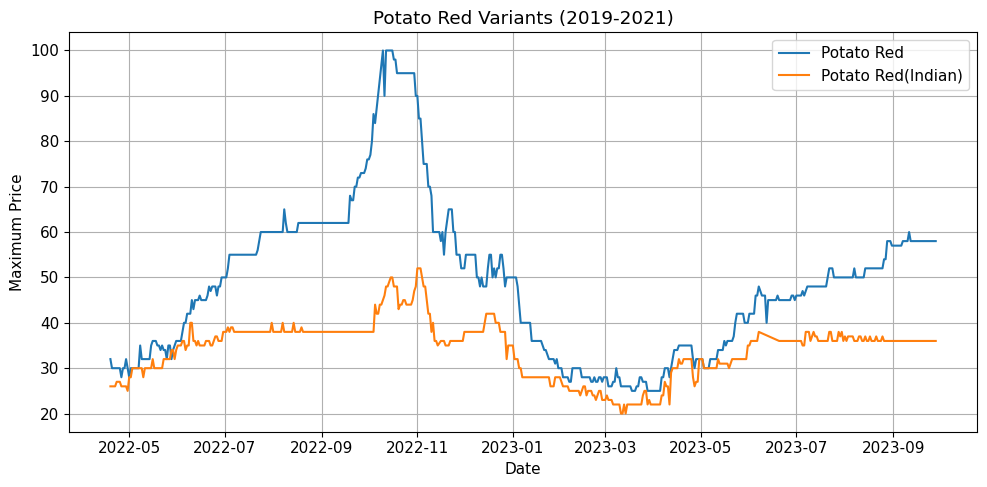

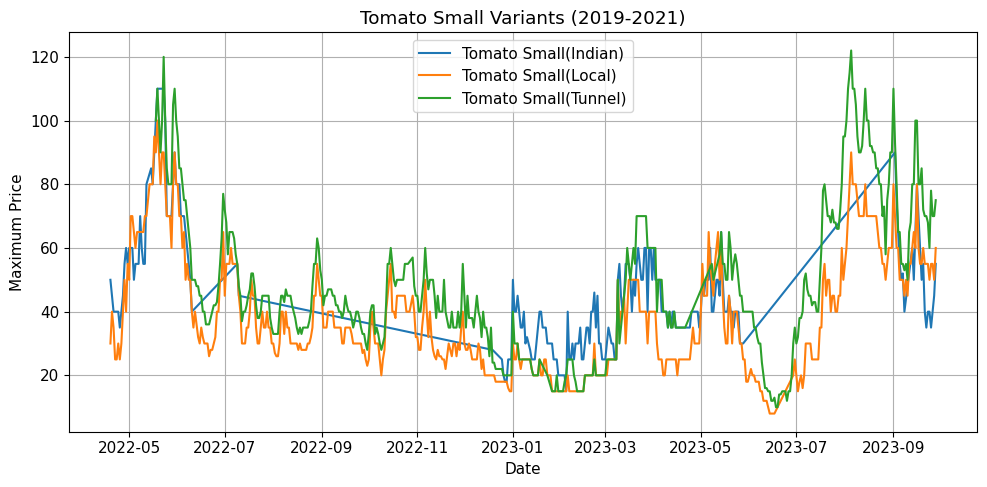

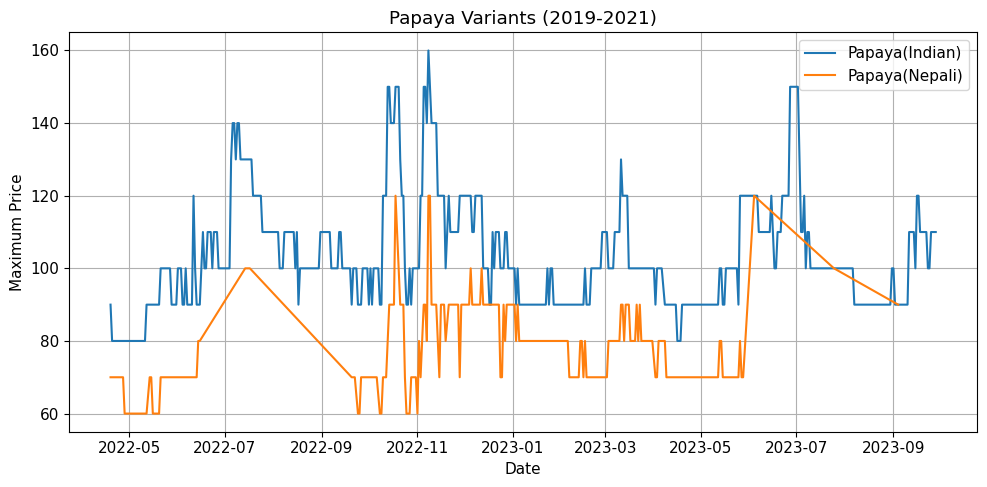

In [30]:
# Group plots (Potato, Tomato, Papaya)

def plot_group_variants(df: pd.DataFrame, group_name: str):
    sub = df[df["Group"] == group_name].copy()
    if sub.empty:
        print(f"[Warning] Group '{group_name}' has no data.")
        return
    fig, ax = plt.subplots()
    for name, g in sub.groupby("Commodity"):
        ax.plot(g["Date"], g["Maximum"], label=name, linewidth=1.5)
    ax.set_title(f"{group_name} Variants (2019-2021)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Maximum Price")
    ax.legend(loc="best")
    plt.tight_layout()
    plt.show()

plot_group_variants(filtered, "Potato Red")
plot_group_variants(filtered, "Tomato Small")
plot_group_variants(filtered, "Papaya")


In [31]:
# Fill gaps (daily index) + time interpolation
def fill_daily_and_interpolate(df: pd.DataFrame) -> pd.DataFrame:
    out = []
    for com, g in df.groupby("Commodity"):
        g = g.sort_values("Date").set_index("Date")
        idx = pd.date_range(g.index.min(), g.index.max(), freq="D")
        g = g.reindex(idx)
        g["Commodity"] = com
        g["Group"] = g["Group"].ffill().bfill()
        g["Maximum"] = g["Maximum"].interpolate(method="time", limit_direction="both")
        out.append(g.reset_index().rename(columns={"index": "Date"}))
    return pd.concat(out, ignore_index=True)

filled = fill_daily_and_interpolate(filtered)
print("Filled shape:", filled.shape)
filled.head()


Filled shape: (3643, 7)


,Date,Commodity,Unit,Minimum,Maximum,Average,Group
0,2022-04-19,Papaya(Indian),KG,80.0,90.0,86.67,Papaya
1,2022-04-20,Papaya(Indian),KG,70.0,80.0,76.67,Papaya
2,2022-04-21,Papaya(Indian),KG,70.0,80.0,76.67,Papaya
3,2022-04-22,Papaya(Indian),KG,70.0,80.0,75.00,Papaya
4,2022-04-23,Papaya(Indian),KG,70.0,80.0,76.67,Papaya


In [32]:
# Train / Test split
train = filled[filled["Date"] < pd.Timestamp("2022-07-01")].copy()
test  = filled[filled["Date"] >= pd.Timestamp("2022-07-01")].copy()

print("Train:", train.shape, " Test:", test.shape)

# Quick sanity check
print("Dtypes after cleaning:\n", data.dtypes)
print("Sample 'Maximum' values:", data["Maximum"].dropna().head().tolist()[:5])


Train: (482, 7)  Test: (3161, 7)
Dtypes after cleaning:
 Commodity            object
Date         datetime64[ns]
Unit                 object
Minimum             float64
Maximum             float64
Average             float64
dtype: object
Sample 'Maximum' values: [40.0, 32.0, 21.0, 16.0, 30.0]


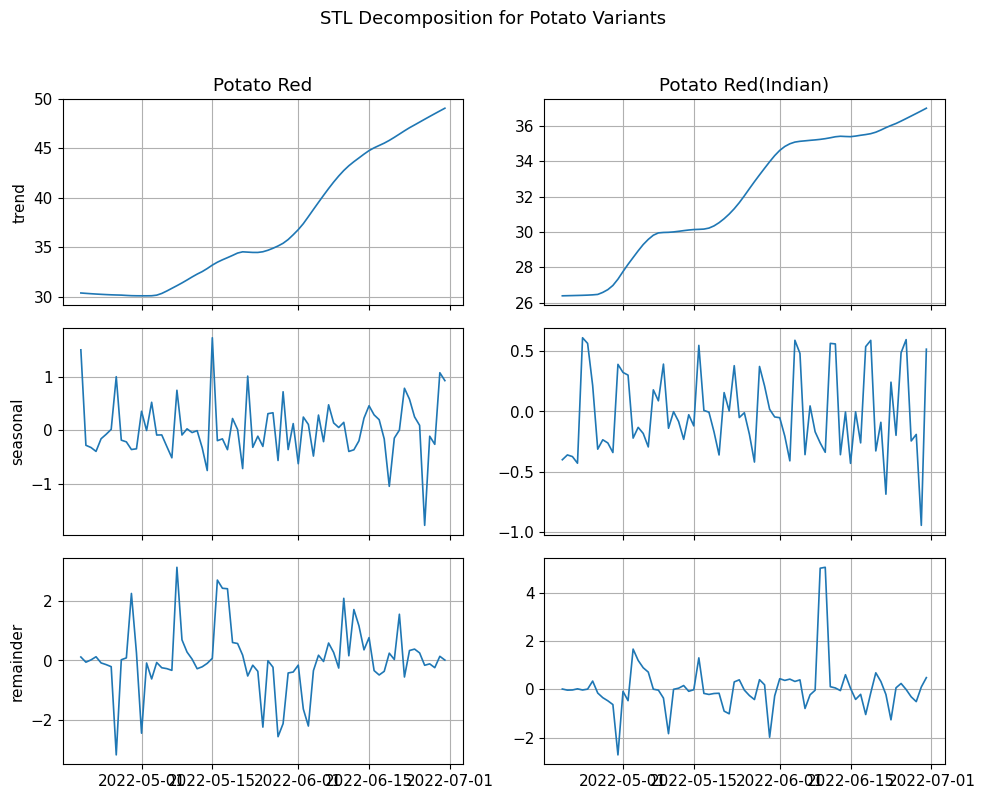

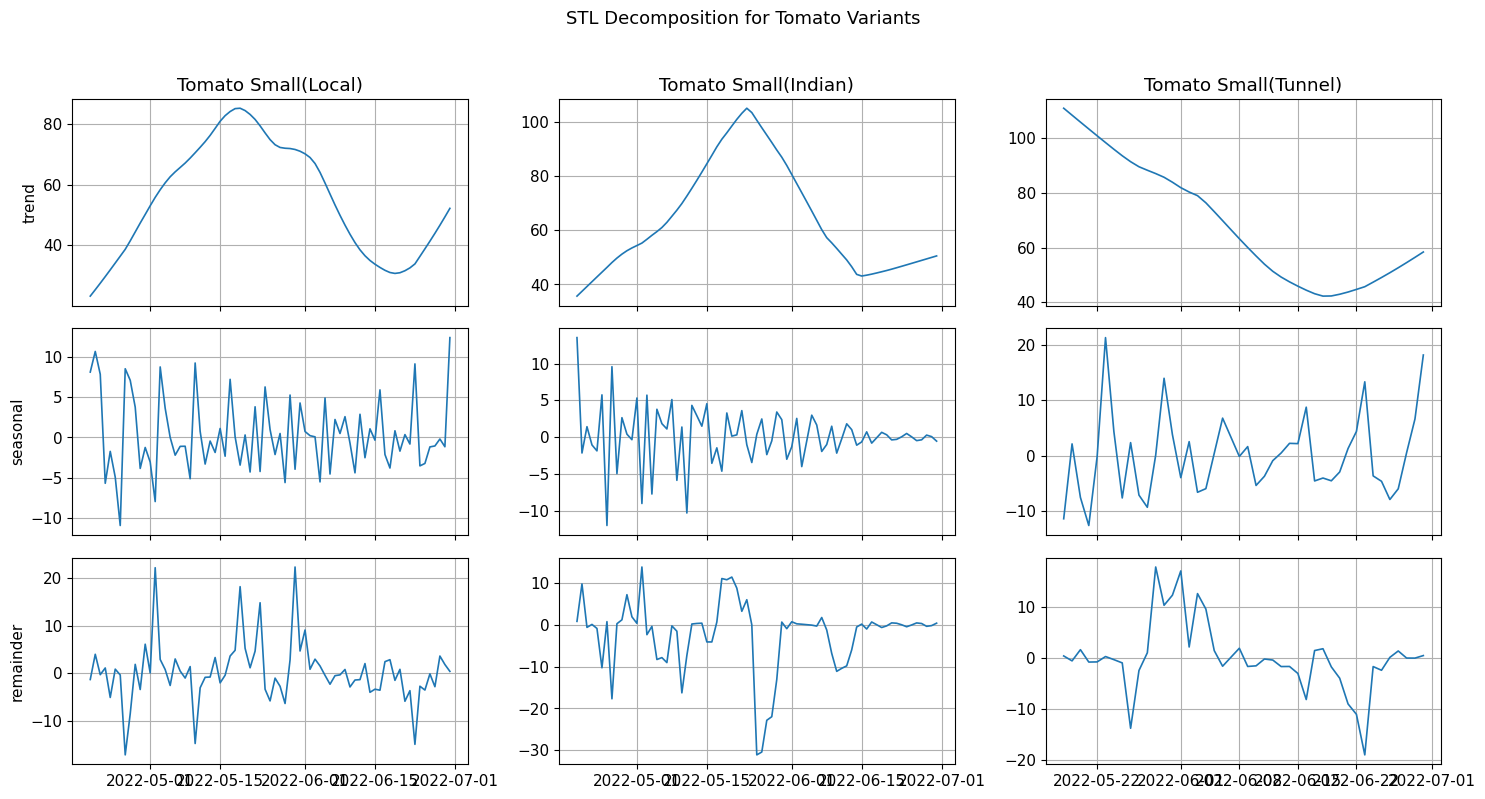

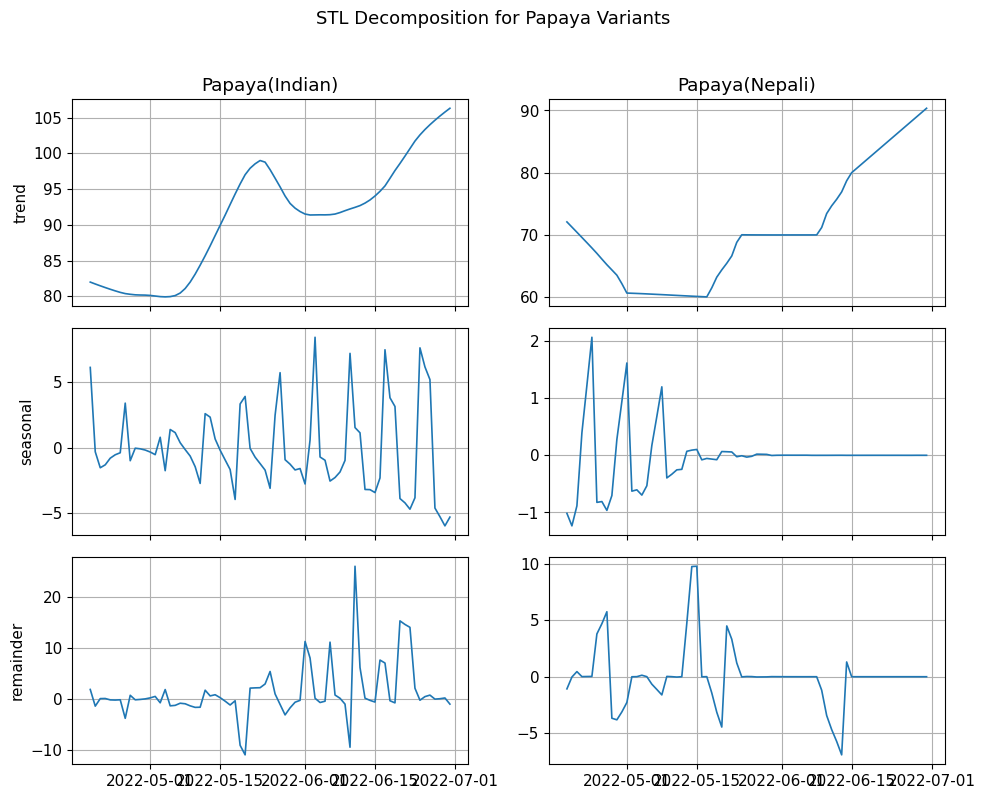

In [33]:
# STL decomposition (per group)
def stl_decompose_plot(train_df: pd.DataFrame, commodity_groups: dict, period: int = 7):
    import numpy as np
    for group_name, commodities in commodity_groups.items():
        parts = []
        for com in commodities:
            s = train_df[train_df["Commodity"] == com].sort_values("Date")
            if s.empty:
                continue
            series = pd.Series(s["Maximum"].values, index=s["Date"])
            res = STL(series, period=period, robust=True).fit()
            parts.append(pd.DataFrame({
                "Date": s["Date"].values, "Commodity": com,
                "trend": res.trend.values, "seasonal": res.seasonal.values, "remainder": res.resid.values
            }))
        if not parts:
            continue
        comps = pd.concat(parts, ignore_index=True)
        comps_long = comps.melt(
            id_vars=["Date", "Commodity"],
            value_vars=["trend", "seasonal", "remainder"],
            var_name="Component", value_name="Value"
        )
        components = ["trend", "seasonal", "remainder"]
        commodities_present = comps_long["Commodity"].unique().tolist()
        n_rows, n_cols = len(components), len(commodities_present)
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 2.6*n_rows), sharex="col")
        if n_rows == 1 and n_cols == 1:
            axes = np.array([[axes]])
        for i, comp in enumerate(components):
            for j, com in enumerate(commodities_present):
                ax = axes[i, j]
                sub = comps_long[(comps_long["Component"] == comp) & (comps_long["Commodity"] == com)]
                ax.plot(sub["Date"], sub["Value"], linewidth=1.2)
                if i == 0: ax.set_title(com)
                if j == 0: ax.set_ylabel(comp)
        fig.suptitle(f"STL Decomposition for {group_name} Variants", y=1.02, fontsize=13)
        plt.tight_layout()
        plt.show()

commodity_groups = {
    "Potato": ["Potato Red", "Potato Red(Indian)"],
    "Tomato": ["Tomato Small(Local)", "Tomato Small(Indian)", "Tomato Small(Tunnel)"],
    "Papaya": ["Papaya(Indian)", "Papaya(Nepali)"]
}
stl_decompose_plot(train, commodity_groups, period=7)


In [34]:
# SARIMAX (ARIMA) modeling + forecast (grid search over small set)

def fit_forecast_sarimax(train_df, test_df, seasonal_period=7,
                         pdq_grid=((0,1,1),(1,1,1),(2,1,1)),
                         PDQ_grid=((0,1,1),(1,1,1))):
    """
    Lightweight grid search over a few (p,d,q) and (P,D,Q,m) combos using SARIMAX.
    Returns:
      - forecast df with columns [Date, Commodity, ARIMA_Forecast]
      - summary dict of chosen orders
    """
    all_fc, summary = [], {}
    for com, g_train in train_df.groupby("Commodity"):
        y = g_train.sort_values("Date")["Maximum"].values
        best_aic, best_order, best_seasonal, best_model = np.inf, None, None, None

        for order in pdq_grid:
            for seas in PDQ_grid:
                seasonal_order = (seas[0], seas[1], seas[2], seasonal_period)
                try:
                    model = SARIMAX(
                        y,
                        order=order,
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False
                    )
                    res = model.fit(disp=False)
                    if res.aic < best_aic:
                        best_aic, best_order, best_seasonal, best_model = res.aic, order, seasonal_order, res
                except Exception:
                    continue

        summary[com] = {"order": best_order, "seasonal_order": best_seasonal, "AIC": best_aic}
        horizon = test_df[test_df["Commodity"] == com].shape[0]
        if horizon > 0 and best_model is not None:
            fc = best_model.forecast(steps=horizon)
            dates = test_df[test_df["Commodity"] == com].sort_values("Date")["Date"].values
            all_fc.append(pd.DataFrame({
                "Date": dates,
                "Commodity": com,
                "ARIMA_Forecast": np.asarray(fc)
            }))

    fc_df = pd.concat(all_fc, ignore_index=True) if all_fc else pd.DataFrame(columns=["Date","Commodity","ARIMA_Forecast"])
    return fc_df, summary

arima_fc, arima_summary = fit_forecast_sarimax(train, test, seasonal_period=7)
print("=== SARIMAX (ARIMA) Model Summary ===")
for k, v in arima_summary.items():
    print(k, v)


=== SARIMAX (ARIMA) Model Summary ===
Papaya(Indian) {'order': (1, 1, 1), 'seasonal_order': (0, 1, 1, 7), 'AIC': np.float64(379.7988221174093)}
Papaya(Nepali) {'order': (0, 1, 1), 'seasonal_order': (0, 1, 1, 7), 'AIC': np.float64(275.0931102152093)}
Potato Red {'order': (0, 1, 1), 'seasonal_order': (0, 1, 1, 7), 'AIC': np.float64(210.92386510826668)}
Potato Red(Indian) {'order': (1, 1, 1), 'seasonal_order': (0, 1, 1, 7), 'AIC': np.float64(196.19758212795404)}
Tomato Small(Indian) {'order': (0, 1, 1), 'seasonal_order': (0, 1, 1, 7), 'AIC': np.float64(388.16545630404437)}
Tomato Small(Local) {'order': (0, 1, 1), 'seasonal_order': (0, 1, 1, 7), 'AIC': np.float64(394.1540045981889)}
Tomato Small(Tunnel) {'order': (0, 1, 1), 'seasonal_order': (1, 1, 1, 7), 'AIC': np.float64(186.40361592001344)}


In [35]:
 #ETS (Holt-Winters) modeling + forecast

def fit_forecast_ets(train_df, test_df, seasonal_period=7):
    all_fc, reports = [], {}
    for com, g_train in train_df.groupby("Commodity"):
        y = g_train.sort_values("Date")["Maximum"].values
        try:
            model = ExponentialSmoothing(y, trend="add", seasonal="add",
                                         seasonal_periods=seasonal_period).fit()
        except Exception:  # fallback if seasonal fails
            model = ExponentialSmoothing(y, trend="add").fit()
        reports[com] = str(model.params)

        horizon = test_df[test_df["Commodity"] == com].shape[0]
        if horizon > 0:
            fc = model.forecast(horizon)
            dates = test_df[test_df["Commodity"] == com].sort_values("Date")["Date"].values
            all_fc.append(pd.DataFrame({
                "Date": dates,
                "Commodity": com,
                "ETS_Forecast": np.asarray(fc)
            }))
    fc_df = pd.concat(all_fc, ignore_index=True) if all_fc else pd.DataFrame(columns=["Date","Commodity","ETS_Forecast"])
    return fc_df, reports

ets_fc, ets_report = fit_forecast_ets(train, test, seasonal_period=7)
print("=== ETS Model Summary ===")
for k, v in ets_report.items():
    print(k, v)


=== ETS Model Summary ===
Papaya(Indian) {'smoothing_level': np.float64(0.3576537155667459), 'smoothing_trend': np.float64(0.0), 'smoothing_seasonal': np.float64(0.0), 'damping_trend': nan, 'initial_level': np.float64(83.00033892911229), 'initial_trend': np.float64(0.2629358718093133), 'initial_seasons': array([-0.6249819 , -0.88804963, -0.24189074,  1.69044709,  2.42745726,
        0.16445746, -0.09840302]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}
Papaya(Nepali) {'smoothing_level': np.float64(0.9999999850988388), 'smoothing_trend': np.float64(0.0), 'smoothing_seasonal': np.float64(1.4843518630327731e-08), 'damping_trend': nan, 'initial_level': np.float64(69.79067581597978), 'initial_trend': np.float64(0.2991866450709446), 'initial_seasons': array([-0.08871496, -0.26235157, -1.28248072, -0.94373487,  0.39501383,
        0.23376795, -0.92749532]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}
Potato Red {'smoothing_level': np.float64(0.6483961291803074), 's

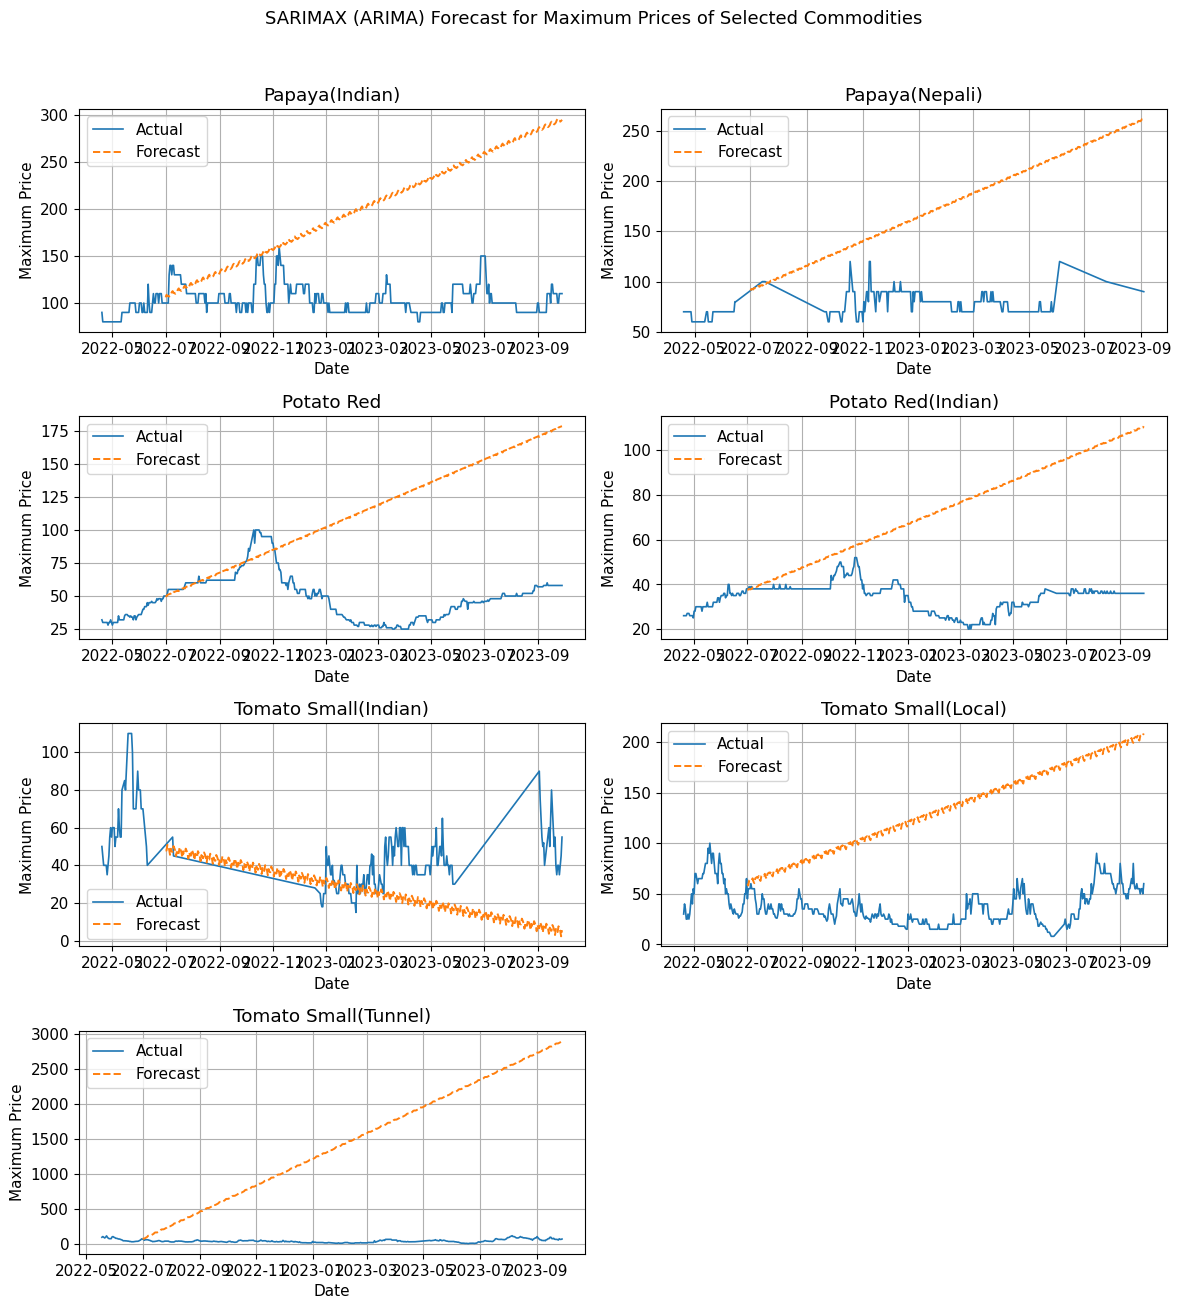

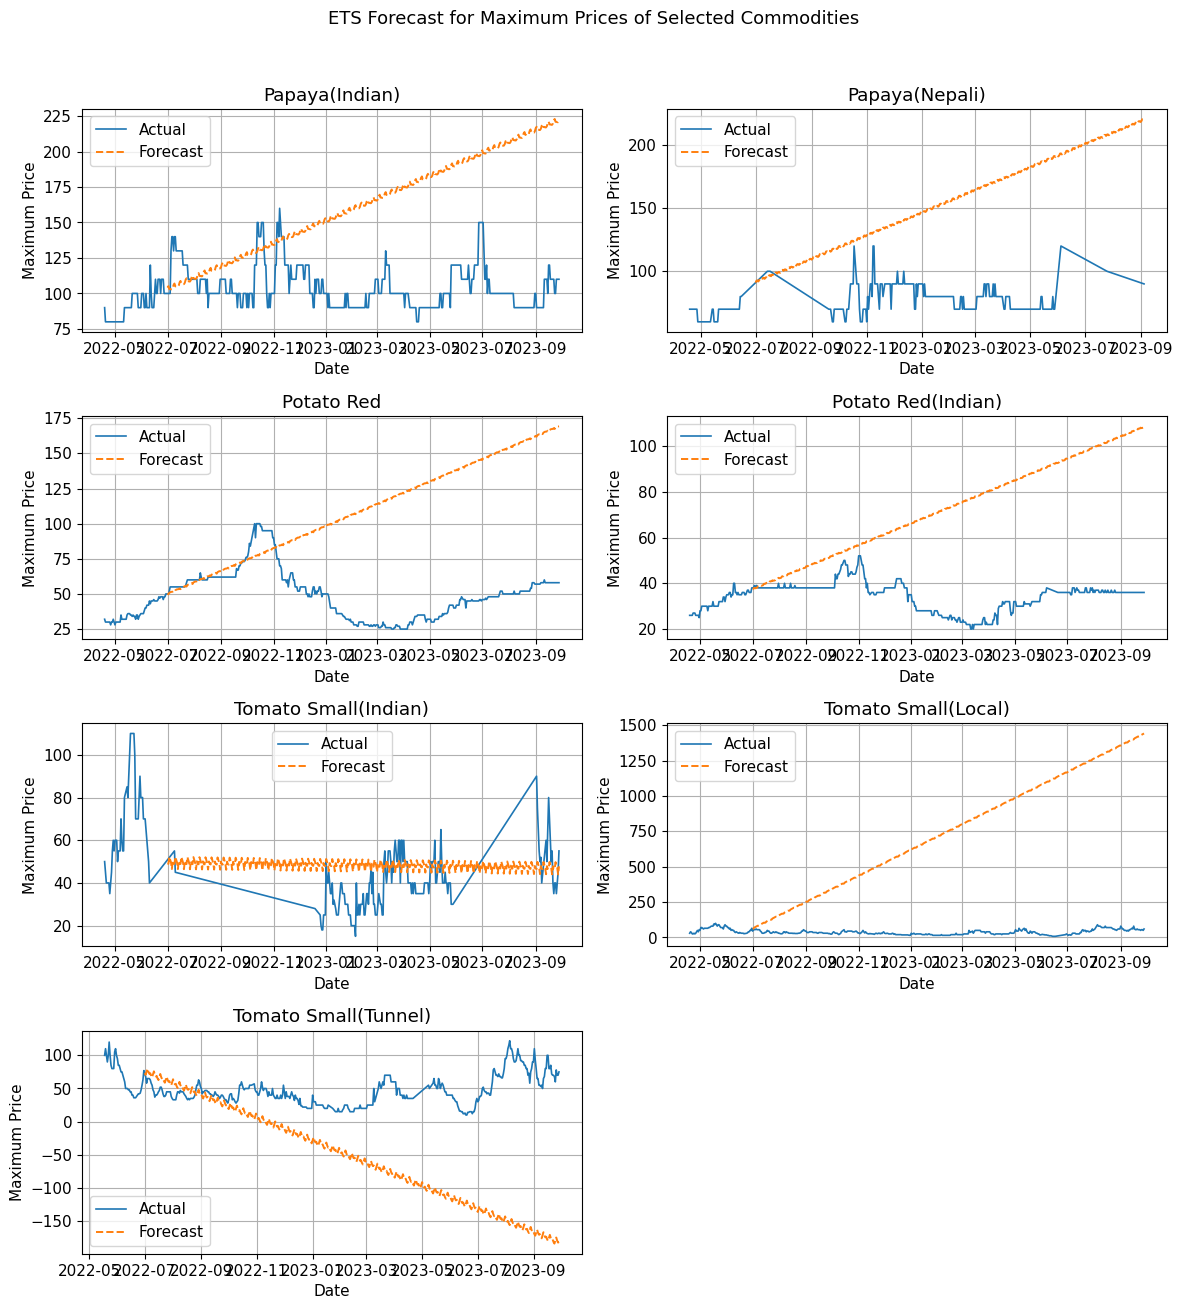

In [36]:
#Plot forecasts (Actual vs Forecast by commodity)

def plot_forecast_panel(base_df, test_df, fc_df, value_col, fc_col, title):
    import numpy as np
    commodities = fc_df["Commodity"].unique().tolist() if not fc_df.empty else base_df["Commodity"].unique().tolist()
    n = len(commodities)
    ncols = 2 if n >= 2 else 1
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 3.2*nrows), sharex=False)
    axes = np.array(axes).reshape(nrows, ncols)

    for idx, com in enumerate(commodities):
        r, c = divmod(idx, ncols)
        ax = axes[r, c]
        full = base_df[base_df["Commodity"] == com].sort_values("Date")
        ax.plot(full["Date"], full[value_col], label="Actual", linewidth=1.2)
        fc_sub = fc_df[fc_df["Commodity"] == com].sort_values("Date")
        if not fc_sub.empty:
            ax.plot(fc_sub["Date"], fc_sub[fc_col], label="Forecast", linestyle="--", linewidth=1.4)
        ax.set_title(com)
        ax.set_xlabel("Date")
        ax.set_ylabel("Maximum Price")
        ax.legend(loc="best")

    # Clear unused axes
    for k in range(idx + 1, nrows * ncols):
        r, c = divmod(k, ncols)
        fig.delaxes(axes[r, c])

    fig.suptitle(title, y=1.02, fontsize=13)
    plt.tight_layout()
    plt.show()

plot_forecast_panel(filled, test, arima_fc, "Maximum", "ARIMA_Forecast",
                    "SARIMAX (ARIMA) Forecast for Maximum Prices of Selected Commodities")
plot_forecast_panel(filled, test, ets_fc, "Maximum", "ETS_Forecast",
                    "ETS Forecast for Maximum Prices of Selected Commodities")


In [37]:
# Accuracy (MAE/RMSE/MAPE) comparison table

def accuracy_metrics(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mape = np.mean(np.abs((y_true - y_pred) / (np.maximum(np.abs(y_true), 1e-8)))) * 100.0
    return mae, rmse, mape

rows = []
for com in test["Commodity"].unique():
    y = test[test["Commodity"] == com].sort_values("Date")["Maximum"].values

    af = arima_fc[arima_fc["Commodity"] == com].sort_values("Date")
    if not af.empty and len(af) == len(y):
        mae, rmse, mape = accuracy_metrics(y, af["ARIMA_Forecast"].values)
        rows.append({"Commodity": com, "Model": "SARIMAX(ARIMA)", "MAE": mae, "RMSE": rmse, "MAPE(%)": mape})

    ef = ets_fc[ets_fc["Commodity"] == com].sort_values("Date")
    if not ef.empty and len(ef) == len(y):
        mae, rmse, mape = accuracy_metrics(y, ef["ETS_Forecast"].values)
        rows.append({"Commodity": com, "Model": "ETS", "MAE": mae, "RMSE": rmse, "MAPE(%)": mape})

combined_accuracy = pd.DataFrame(rows).sort_values(["Commodity", "Model"]).reset_index(drop=True)
combined_accuracy


,Commodity,Model,MAE,RMSE,MAPE(%)
0,Papaya(Indian),ETS,60.425963,70.747209,60.977089
1,Papaya(Indian),SARIMAX(ARIMA),97.683705,113.539531,98.171812
2,Papaya(Nepali),ETS,70.254763,78.880712,85.009497
3,Papaya(Nepali),SARIMAX(ARIMA),90.883910,102.500073,109.198120
4,Potato Red,ETS,61.751353,74.276869,157.271226
5,Potato Red,SARIMAX(ARIMA),65.924360,79.413610,167.697143
6,Potato Red(Indian),ETS,38.423458,44.867252,122.686691
7,Potato Red(Indian),SARIMAX(ARIMA),39.469618,46.092384,125.934051
8,Tomato Small(Indian),ETS,13.626640,16.134893,36.221451
9,Tomato Small(Indian),SARIMAX(ARIMA),19.606915,28.965696,38.120085
